# **AI Date Type Classification**

**We have 9 different types of dates used for classification. This is used for the AI to detect by default the type of date that is being harvested by detecting the date from the 9 most popular types used.**

# **1) Downloading the dataset from kaggle and unzipping the file**

Unlike the other codes, here we directly upload the datasets from kaggle itself.

In [1]:
!kaggle datasets download -d wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment

Dataset URL: https://www.kaggle.com/datasets/wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.11G/3.11G [00:44<00:00, 131MB/s]
100% 3.11G/3.11G [00:44<00:00, 75.1MB/s]


In [2]:
!unzip date-fruit-image-dataset-in-controlled-environment.zip -d /content/date_fruit_dataset

Archive:  date-fruit-image-dataset-in-controlled-environment.zip
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (1).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (10).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (100).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (101).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (102).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (103).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (104).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (105).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (106).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (107).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (108).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (109).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date (11).JPG  
  inflating: /content/date_fruit_dataset/Ajwa/Ajwa Date

# **2) Importing Statements**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models

# This is for spliting the data
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# This is for visualization purposes
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

import os
from PIL import Image

# **3) Making a custom dataset**

In [4]:
dataset_dir = '/content/date_fruit_dataset'

class DateClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, sub_dir in enumerate(os.listdir(root_dir)):
            sub_dir_path = os.path.join(root_dir, sub_dir)
            if os.path.isdir(sub_dir_path):
                for img_file in os.listdir(sub_dir_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(sub_dir_path, img_file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# **4) Data Augmentation**

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

# **5) Data Splitting**

In [7]:
full_dataset = DateClassificationDataset(root_dir=dataset_dir, transform=transform)
indices = list(range(len(full_dataset)))

train_indices, val_indices = train_test_split(indices, test_size=0.2, train_size=0.8, random_state=42)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

num_images = len(full_dataset)
print(f"Number of Images: {num_images}")

Number of Images: 1658


# **6) Data Loader**

In [8]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# **7) Model**

In [9]:
# Load pretrained ResNet model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes
num_classes = len(os.listdir(dataset_dir))  # Number of classes based on subdirectories
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.6MB/s]


# **8) Training the model**

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

################################### Training Accuracy ##########################################################

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        train_acc = correct.double() / total
        train_acc_history.append(train_acc)
        print(f'Training Loss: {running_loss / total:.4f}, Training Accuracy: {train_acc:.4f}')

################################### Validation Accuracy ##########################################################

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
                val_total += labels.size(0)
                val_loss += loss.item() * inputs.size(0)

        val_acc = val_correct.double() / val_total
        val_acc_history.append(val_acc)
        print(f'Validation Loss: {val_loss / val_total:.4f}, Validation Accuracy: {val_acc:.4f}')

    return train_acc_history, val_acc_history

train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10
Training Loss: 0.5119, Training Accuracy: 0.8235
Validation Loss: 4.7325, Validation Accuracy: 0.3464
Epoch 2/10
Training Loss: 0.3007, Training Accuracy: 0.9027
Validation Loss: 1.4065, Validation Accuracy: 0.6325
Epoch 3/10
Training Loss: 0.1907, Training Accuracy: 0.9359
Validation Loss: 1.0042, Validation Accuracy: 0.6988
Epoch 4/10
Training Loss: 0.1438, Training Accuracy: 0.9502
Validation Loss: 0.1989, Validation Accuracy: 0.9518
Epoch 5/10
Training Loss: 0.1357, Training Accuracy: 0.9540
Validation Loss: 0.1589, Validation Accuracy: 0.9669
Epoch 6/10
Training Loss: 0.1335, Training Accuracy: 0.9593
Validation Loss: 1.0307, Validation Accuracy: 0.7078
Epoch 7/10
Training Loss: 0.1436, Training Accuracy: 0.9502
Validation Loss: 0.5000, Validation Accuracy: 0.8464
Epoch 8/10
Training Loss: 0.0821, Training Accuracy: 0.9721
Validation Loss: 0.3830, Validation Accuracy: 0.8855
Epoch 9/10
Training Loss: 0.1043, Training Accuracy: 0.9623
Validation Loss: 0.8210, Validation 

# **9) Data visualization**

In [11]:
train_acc_cpu = [acc.cpu().numpy() for acc in train_acc]
val_acc_cpu = [acc.cpu().numpy() for acc in val_acc]

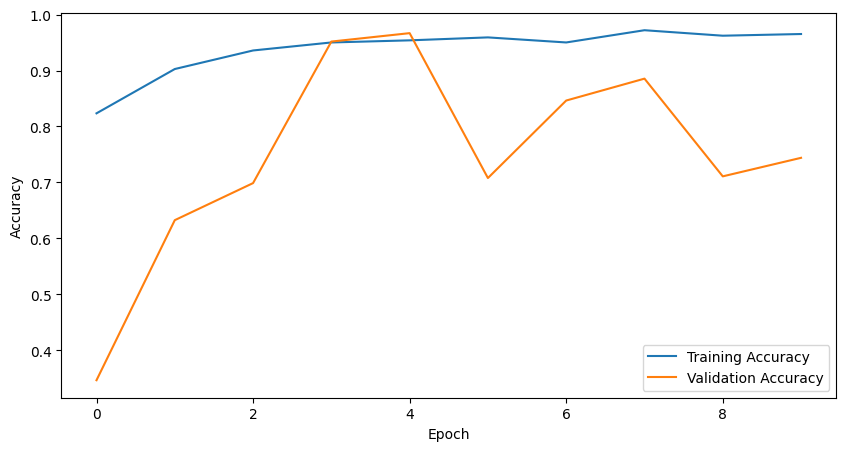

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_cpu, label='Training Accuracy')
plt.plot(val_acc_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()